In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from h5py import File
import os
import csv

RGBs = ['r', 'g', 'b']

In [2]:
from ImgProcess import Show     # import all functions from ../Codes/ImgProcessing.py
from KSVD import Learn              # import all functions from ../Codes/KSVD.py
from ResultTest import PSNR

In [3]:
# read the gray scale images
imgList_gray = [file[: -4] for file in os.listdir('../Images/') if file.endswith('.png')]
imgList_rgb = [file[: -4] for file in os.listdir('../Images/McM images/') if file.endswith('.tif')]

# Task 1. 灰色图像的字典学习算法

使用 K-SVD 算法对灰度图像进行字典学习. 

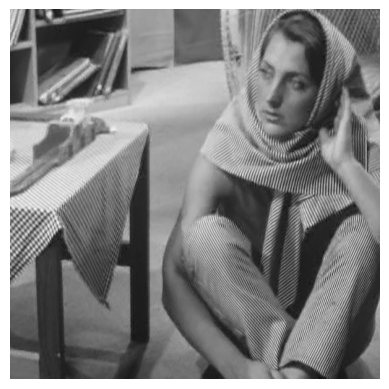

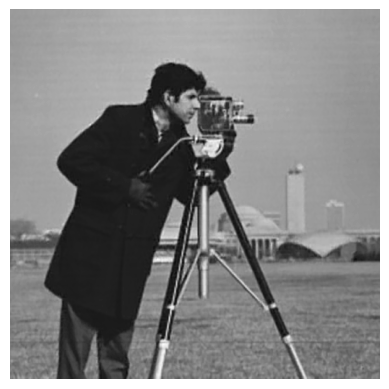

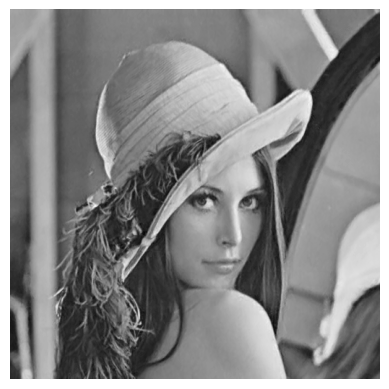

In [4]:
size = 16
sparsity = 6
eps = 1e-4

for fileName in imgList_gray:
    img = plt.imread('../Images/' + fileName + '.png')

    img_learned, mD = Learn(img, size, sparsity, 100, eps=eps)
    # print(PSNR(img, img_learned))
    
    Img_learned = Show(img_learned)
    # plt.imsave('../results/' + fileName + '.png', Img_learned, cmap='gray')

# Task 2&3. 彩色图像的字典学习算法与降噪

In [4]:
with open('../results/PSNR.csv', 'w', newline='') as f_psnr:
    writer = csv.writer(f_psnr)
    writer.writerow(['image', 'r', 'g', 'b', 'rgb'])

In [22]:
size = 16
sparsity = 6
eps = 1e-4

for fileName in imgList_rgb:
    # load the image
    img_clear = plt.imread('../Images/McM images/' + fileName + '.tif') / 255
    img_noisy = File('../Images/McM images/' + fileName + '_noise.mat')
    img_noisy = [_.T / 255 for _ in img_noisy['u_n']]

    # learn the dictionary for each channel
    len_dict = 2 + (size + 2) * (int(size * 2**0.5) + 1)
    img_dict = np.ones((len_dict, len_dict, 3))

    img_denoised = []
    psnr = {}

    # i = 1 
    # color = 'g'
    # if True:
    for i, color in enumerate(RGBs):
        # extract the channel
        channel = img_clear[:, :, i]
        channel_noisy = img_noisy[i]

        # learn the dictionary
        _, mD = Learn(channel, size, sparsity, 100, eps=eps)

        # denoise the image using the learned dictionary
        # denoise the channel: use max_iter=1 only learning once for the sparse coding
        channel_denoised, _ = Learn(channel_noisy, size, 1, eps=1e-7, mD=mD)
        # calculate the PSNR value
        psnr[color] = PSNR(channel, channel_denoised)

        # normalize the channel
        channel_denoised = (channel_denoised - channel_denoised.min()) / (channel_denoised.max() - channel_denoised.min())
        img_denoised.append(channel_denoised)

        # save the dictionary
        mDD = (mD - mD.min()) / (mD.max() - mD.min())
        for j in range(mDD.shape[1]):
            atom = mDD[:, j].reshape((size, size))
            idx = np.unravel_index(j, (int(size * 2**0.5) + 1, int(size * 2**0.5) + 1))
            x = idx[0] * (size + 2) + 2
            y = idx[1] * (size + 2) + 2
            img_dict[x:x + size, y:y + size, i] = atom

    img_denoised = np.stack(img_denoised, axis=2)
    # save the denoised image
    path_img = '../results/images denoised/' + fileName + '_denoised.png'
    plt.imsave(path_img, img_denoised)
    
    plt.imsave('../results/dictionaries/' + fileName + '_dict.png', img_dict)
    
    # write the PSNR value to the csv file
    psnr['rgb'] = (psnr['r'] + psnr['g'] + psnr['b']) / 3
    with open('../results/PSNR.csv', 'a', newline='') as f_psnr:
        writer = csv.writer(f_psnr)
        writer.writerow([fileName, psnr['r'], psnr['g'], psnr['b'], psnr['rgb']])